In [2]:
### Run once in the new env
%pip install -r requirements.txt -q
!python -m pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


#### Initialization

In [1]:
## libraries 
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from pymongo import MongoClient
from time import time 
import seaborn as sns
import pandas as pd 
import dotenv
import json 
import os 

plt.style.use('dark_background')

In [2]:
## database initialization
dotenv.load_dotenv()


MYSQL_CONFIG = {
    'username': os.environ['mysql_username'],
    'password': os.environ['mysql_password'],
    'host'    : os.environ['mysql_hostname'],
}

MONGO_DB_CONFIG = {
    'username': os.environ['mongo_username'],
    'password': os.environ['mongo_password'],
    'hostname' : os.environ['mongo_hostname'],
    'appName' : os.environ['mongo_appName'],
    'port'    : os.environ['mongo_port']
}

DB_NAME = 'project_test'

In [4]:
def reset_sqlite_database(engine, dbname : str):
    with engine.connect() as connection:
        connection.execute(text(f"DROP DATABASE IF EXISTS {dbname}"))
        connection.execute(text(f"CREATE DATABASE {dbname}"))
    print(f'Recreated the database : [{dbname}]')

In [5]:
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306"
engine = create_engine(db_url)
reset_sqlite_database(engine, dbname = DB_NAME)
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306/{DB_NAME}"
engine = create_engine(db_url)

Recreated the database : [project_test]


In [6]:
data_folder = 'finance_transaction'
transaction_filename = os.path.join(data_folder, 'transactions_data.csv')
cards_filename = os.path.join(data_folder, 'cards_data.csv')
users_filename = os.path.join(data_folder, 'users_data.csv')

n_rows = 1000 # using limited rows due to large number of rows  
transaction_df = pd.read_csv(transaction_filename, nrows= n_rows)
cards_df = pd.read_csv(cards_filename, nrows= n_rows)
users_df = pd.read_csv(users_filename, nrows= n_rows)

In [7]:
transaction_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [8]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [9]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [10]:
users_df.describe()

,id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,credit_score,num_credit_cards
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000
mean,1010.984000,44.591000,66.309000,1974.595000,6.57200,37.45297,-91.714640,708.131000,3.053000
std,573.001693,18.151341,3.678185,18.157276,3.58576,5.19272,16.540147,68.063959,1.618274
min,0.000000,18.000000,50.000000,1918.000000,1.00000,21.30000,-159.410000,488.000000,1.000000
25%,529.250000,29.000000,65.000000,1962.000000,3.00000,33.91000,-97.632500,676.000000,2.000000
50%,1016.500000,43.000000,66.000000,1976.000000,7.00000,38.41000,-86.565000,711.000000,3.000000
75%,1499.750000,57.000000,68.000000,1990.000000,10.00000,41.29000,-80.130000,751.000000,4.000000
max,1997.000000,101.000000,79.000000,2002.000000,12.00000,61.20000,-68.670000,850.000000,9.000000


In [11]:
cards_df.describe()

,id,client_id,card_number,cvv,num_cards_issued,year_pin_last_changed
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,2983.041000,1047.456000,4.871489e+15,526.081000,1.511000,2013.478000
std,1812.382743,568.164294,1.235536e+15,284.875163,0.515893,4.339164
min,4.000000,11.000000,3.007170e+14,2.000000,1.000000,2003.000000
25%,1464.750000,628.000000,4.506775e+15,286.750000,1.000000,2010.000000
50%,2940.500000,1027.000000,5.118204e+15,544.500000,2.000000,2012.000000
75%,4540.500000,1547.000000,5.582174e+15,771.750000,2.000000,2018.000000
max,6138.000000,1990.000000,6.969946e+15,999.000000,3.000000,2020.000000


In [12]:
transaction_df.describe()

,id,client_id,card_id,merchant_id,zip,mcc
count,1.000000e+03,1000.000000,1000.00000,1000.000000,864.000000,1000.000000
mean,7.475914e+06,1026.363000,3363.49200,48107.084000,52386.432870,5561.908000
std,3.451566e+02,578.756107,1710.01342,25178.136671,29857.319543,763.350245
min,7.475327e+06,2.000000,0.00000,106.000000,1602.000000,3174.000000
25%,7.475614e+06,513.250000,2228.00000,27092.000000,28283.250000,5311.000000
50%,7.475902e+06,1078.000000,3420.00000,46284.000000,49494.500000,5499.000000
75%,7.476211e+06,1520.500000,4703.25000,65981.500000,78176.500000,5812.000000
max,7.476515e+06,1998.000000,5990.00000,99695.000000,98528.000000,8099.000000


In [13]:
def print_col_names_in_df(columns, title = ''):
    print(f' [ {title} ] '.center(80, '='))
    print(pd.DataFrame({
        'column names' : columns
    }).T)
    print()

In [14]:
# uct = [users_df, cards_df, transaction_df]
print_col_names_in_df(users_df.columns, 'Users DF')
print_col_names_in_df(cards_df.columns, 'Cards DF')
print_col_names_in_df(transaction_df.columns, 'Transactions DF')

================================= [ Users DF ] =================================
              0            1               2           3            4   \
column names  id  current_age  retirement_age  birth_year  birth_month   

                  5        6         7          8                  9   \
column names  gender  address  latitude  longitude  per_capita_income   

                         10          11            12                13  
column names  yearly_income  total_debt  credit_score  num_credit_cards  

================================= [ Cards DF ] =================================
              0          1           2          3            4        5    6   \
column names  id  client_id  card_brand  card_type  card_number  expires  cvv   

                    7                 8             9               10  \
column names  has_chip  num_cards_issued  credit_limit  acct_open_date   

                                 11                12  
column names  year_pin_la

In [15]:
def null_heatmap(df: pd.DataFrame, title = ''):
    nulls = df.isna().sum()
    nulls = nulls.to_frame()  
    # nulls = nulls.T

    sns.heatmap(nulls, annot = True, fmt = 'd', cmap = 'icefire')
    plt.title(title)
    plt.xticks(ticks=[.5], labels=[f'Total Count : {nulls.values.sum()}'])

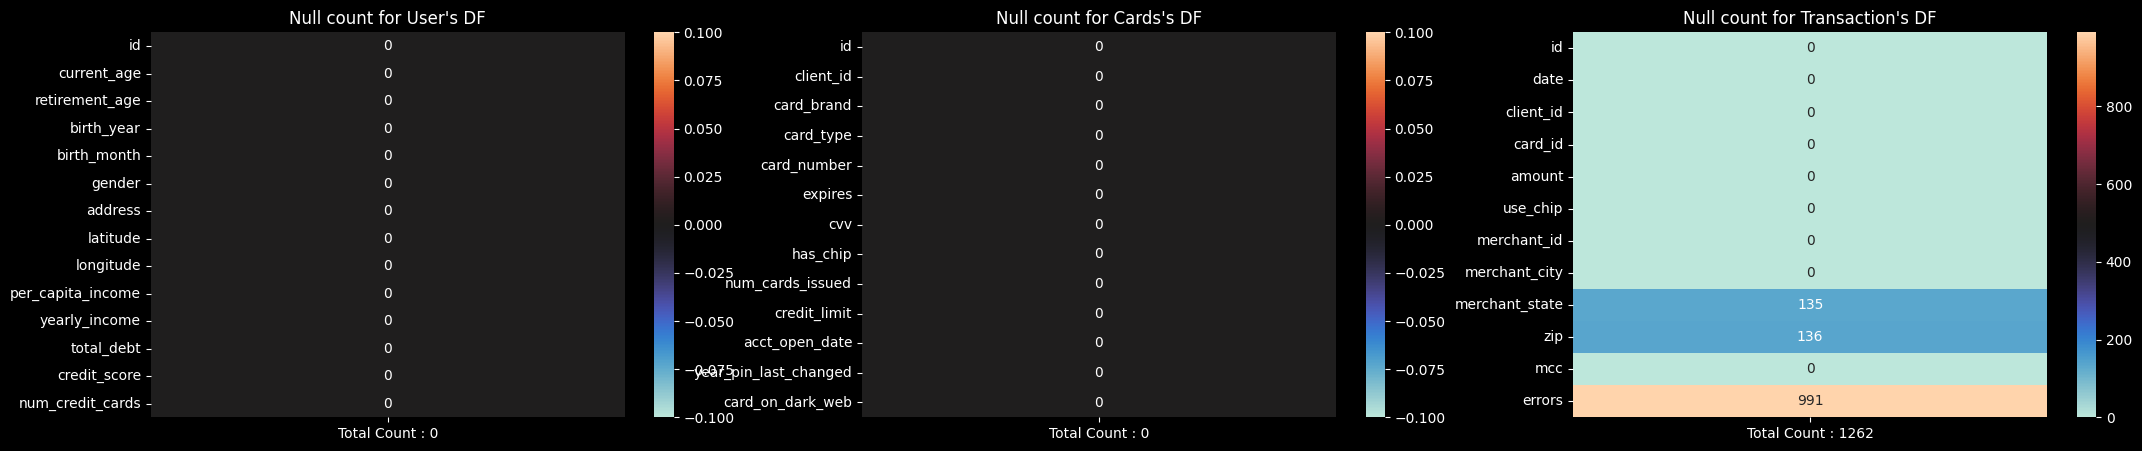

In [17]:
plt.figure(figsize=(26, 5))
plt.tight_layout()

plt.subplot(1,3, 1)
null_heatmap(users_df, "Null count for User's DF")
plt.subplot(1,3, 2)
null_heatmap(cards_df, "Null count for Cards's DF")
plt.subplot(1,3, 3)
null_heatmap(transaction_df, "Null count for Transaction's DF")

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1000 non-null   int64  
 1   current_age        1000 non-null   int64  
 2   retirement_age     1000 non-null   int64  
 3   birth_year         1000 non-null   int64  
 4   birth_month        1000 non-null   int64  
 5   gender             1000 non-null   object 
 6   address            1000 non-null   object 
 7   latitude           1000 non-null   float64
 8   longitude          1000 non-null   float64
 9   per_capita_income  1000 non-null   object 
 10  yearly_income      1000 non-null   object 
 11  total_debt         1000 non-null   object 
 12  credit_score       1000 non-null   int64  
 13  num_credit_cards   1000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 109.5+ KB


`per_capita_income` & `yearly_income` & `total_dept` can be usefull during our analysis so we can clean and convert them from object to float64

In [19]:
remove_currency = lambda x: float(x.replace('$','').strip())
users_df['per_capita_income'] = users_df.per_capita_income.apply(remove_currency)
users_df['yearly_income'] = users_df.yearly_income.apply(remove_currency)
users_df['total_debt'] = users_df.total_debt.apply(remove_currency)
users_df[['per_capita_income', 'yearly_income', 'total_debt']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   per_capita_income  1000 non-null   float64
 1   yearly_income      1000 non-null   float64
 2   total_debt         1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


In [20]:
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1000 non-null   int64 
 1   client_id              1000 non-null   int64 
 2   card_brand             1000 non-null   object
 3   card_type              1000 non-null   object
 4   card_number            1000 non-null   int64 
 5   expires                1000 non-null   object
 6   cvv                    1000 non-null   int64 
 7   has_chip               1000 non-null   object
 8   num_cards_issued       1000 non-null   int64 
 9   credit_limit           1000 non-null   object
 10  acct_open_date         1000 non-null   object
 11  year_pin_last_changed  1000 non-null   int64 
 12  card_on_dark_web       1000 non-null   object
dtypes: int64(6), object(7)
memory usage: 101.7+ KB


`credit_limit` can be used for analysis too 

In [21]:
cards_df['credit_limit'] = cards_df.credit_limit.apply(remove_currency)
cards_df[['credit_limit']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   credit_limit  1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


In [22]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   date            1000 non-null   object 
 2   client_id       1000 non-null   int64  
 3   card_id         1000 non-null   int64  
 4   amount          1000 non-null   object 
 5   use_chip        1000 non-null   object 
 6   merchant_id     1000 non-null   int64  
 7   merchant_city   1000 non-null   object 
 8   merchant_state  865 non-null    object 
 9   zip             864 non-null    float64
 10  mcc             1000 non-null   int64  
 11  errors          9 non-null      object 
dtypes: float64(1), int64(5), object(6)
memory usage: 93.9+ KB


In [23]:
transaction_df['amount'] = transaction_df.amount.apply(remove_currency)
transaction_df[['amount']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB


Since most of the rows will be None for the `errors` from `transactions_df`, lets replace it with `No Errors`

In [24]:
transaction_df.errors.unique()

array([nan, 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance'], dtype=object)

In [25]:
transaction_df['errors'] = transaction_df.errors.fillna('No Errors')
transaction_df.errors.unique()

array(['No Errors', 'Technical Glitch', 'Bad Expiration',
       'Bad Card Number', 'Insufficient Balance'], dtype=object)

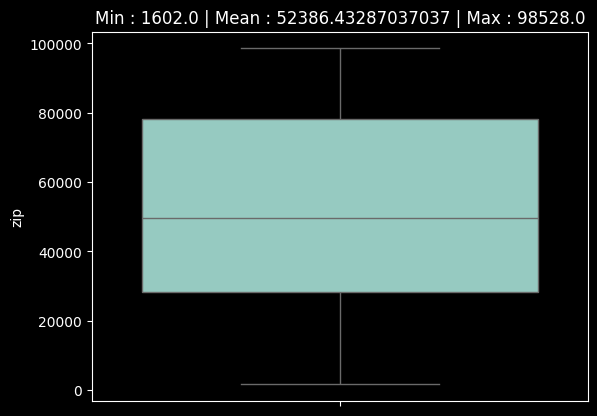

In [26]:
sns.boxplot(transaction_df.zip);
plt.title(f"Min : {transaction_df.dropna().zip.min()} | Mean : {transaction_df.dropna().zip.mean()} | Max : {transaction_df.dropna().zip.max()}");

In [27]:
transaction_df['zip'] = transaction_df.zip.fillna('0')
transaction_df['merchant_state'] = transaction_df.merchant_state.fillna('Unknown')

<span style="color: green;font-weight: bold">All the datasets required for the analysis are cleaned and ready to use</span>

In [125]:
nfolder = 'analysis_data'
if nfolder not in os.listdir():
    os.mkdir(nfolder)

[idf.to_csv(os.path.join(nfolder, iname)) for idf, iname in [(users_df, 'users_data.csv'), (cards_df, 'cards_data.csv'), (transaction_df, 'transactions_data.csv')]]

[None, None, None]

#### MYSQL

In [126]:
### inserting to the mysql database 

users_df.to_sql('users', con=engine, if_exists='replace', method='multi')
cards_df.to_sql('cards', con=engine, if_exists='replace', method='multi')
transaction_df.to_sql('transactions', con=engine, if_exists='replace', method='multi')

1000

#### Mongo DB

In [28]:

uri = f'mongodb://{MONGO_DB_CONFIG["hostname"]}:{MONGO_DB_CONFIG["port"]}/?directConnection=true&serverSelectionTimeoutMS=2000&appName={MONGO_DB_CONFIG["appName"]}+2.3.3'
client = MongoClient(uri)
client.test

Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True, directconnection=True, serverselectiontimeoutms=2000, appname='mongosh 2.3.3'), 'test')

In [31]:
# Test the connection
try:
    db = client[DB_NAME]
    print(f"Connected to the Database: [{DB_NAME}]")
    
    server_status = db.command("serverStatus")
    print("Server Status:", server_status)
except Exception as e:
    print("Could not connect to MongoDB:", e)

Connected to the Database: [project_test]
Server Status: {'host': 'jaabir', 'version': '8.0.3', 'process': 'C:\\Program Files\\MongoDB\\Server\\8.0\\bin\\mongod.exe', 'service': ['shard'], 'pid': 14896, 'uptime': 1922.0, 'uptimeMillis': 1920152, 'uptimeEstimate': 1920, 'localTime': datetime.datetime(2024, 11, 25, 20, 59, 50, 973000), 'asserts': {'regular': 0, 'warning': 0, 'msg': 0, 'user': 17, 'tripwire': 0, 'rollovers': 0}, 'batchedDeletes': {'batches': 0, 'docs': 0, 'stagedSizeBytes': 0, 'timeInBatchMillis': 0, 'refetchesDueToYield': 0}, 'catalogStats': {'collections': 0, 'capped': 0, 'clustered': 0, 'timeseries': 0, 'views': 0, 'internalCollections': 3, 'internalViews': 0, 'csfle': 0, 'queryableEncryption': 0}, 'changeStreamPreImages': {'purgingJob': {'totalPass': 0, 'docsDeleted': 0, 'bytesDeleted': 0, 'scannedCollections': 0, 'scannedInternalCollections': 0, 'maxStartWallTimeMillis': 0, 'timeElapsedMillis': 0}}, 'collectionCatalog': {'numScansDueToMissingMapping': 0}, 'connection

In [33]:
db.list_collection_names()

[]

In [34]:
users_collection = db['users']
cards_collection = db['cards']
transactions_collection = db['transactions']

In [39]:
users_collection.insert_many(users_df.to_dict(orient='records'), ordered= False)
cards_collection.insert_many(cards_df.to_dict(orient='records'), ordered= False)
transactions_collection.insert_many(transaction_df.to_dict(orient='records'), ordered= False)

In [41]:
for i in users_collection.find({}):
    print(i)
    break

{'_id': ObjectId('6744e75c36aedffa4bac0c25'), 'id': 825, 'current_age': 53, 'retirement_age': 66, 'birth_year': 1966, 'birth_month': 11, 'gender': 'Female', 'address': '462 Rose Lane', 'latitude': 34.15, 'longitude': -117.76, 'per_capita_income': 29278.0, 'yearly_income': 59696.0, 'total_debt': 127613.0, 'credit_score': 787, 'num_credit_cards': 5}
